In [1]:
!pip install -U -q PyDrive

In [2]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
!mkdir data

In [5]:
file_id = '1KiOvhsdjJqaUCLJa5adZXEtQ_72s8Eb6'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('data/checking-logs.sqlite')

In [6]:
conn = sqlite3.connect('data/checking-logs.sqlite')

In [7]:
timestamp = pd.io.sql.read_sql(
    "select timestamp from checker where uid like 'user_%'",
    conn, parse_dates=['timestamp']
    )

In [8]:
timestamp.head()

,timestamp
0,2020-04-17 05:19:02.744528
1,2020-04-17 05:22:35.249331
2,2020-04-17 05:22:45.549397
3,2020-04-17 05:34:14.691200
4,2020-04-17 05:34:24.422370


In [9]:
conn.close()

In [10]:
timestamp['date'] = timestamp['timestamp'].dt.floor('d')
timestamp['time'] = np.where(timestamp['timestamp'].dt.hour < 12, 'am', 'pm')
timestamp = timestamp.drop('timestamp', axis=1)

In [11]:
timestamp.head()

,date,time
0,2020-04-17,am
1,2020-04-17,am
2,2020-04-17,am
3,2020-04-17,am
4,2020-04-17,am


In [12]:
df = timestamp.groupby('time').date.value_counts().unstack(0, fill_value=0)
df = df.rename_axis(None, axis=1)
df = df.reset_index()
df['target'] = np.where(df['date'].dt.dayofweek < 5, 'working_day', 'weekend')

In [13]:
df.head()

,date,am,pm,target
0,2020-04-17,21,2,working_day
1,2020-04-18,1,68,weekend
2,2020-04-19,18,15,weekend
3,2020-04-20,2,23,working_day
4,2020-04-21,0,25,working_day


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    35 non-null     datetime64[ns]
 1   am      35 non-null     int64         
 2   pm      35 non-null     int64         
 3   target  35 non-null     object        
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 1.2+ KB


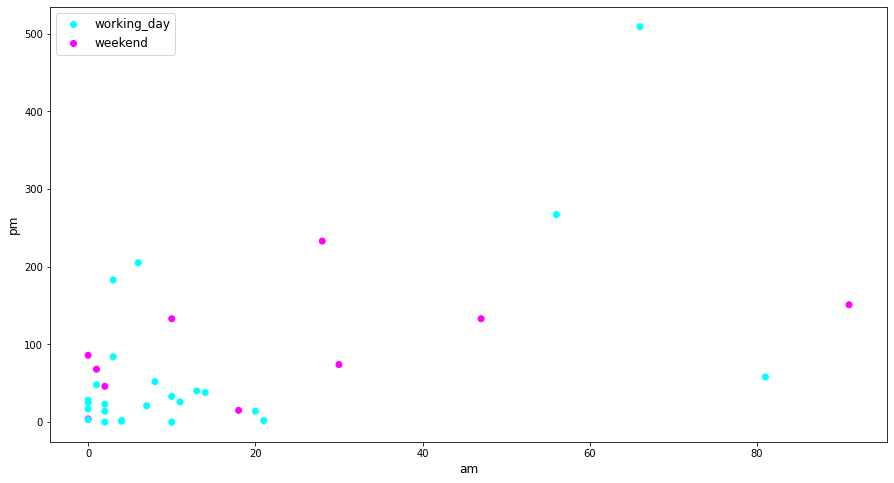

In [15]:
fig, ax = plt.subplots(figsize=(15, 8))
scatter = ax.scatter(x=df['am'], y=df['pm'],
           c=np.where(df['target'] == 'working_day', 0, 1), cmap='cool')
ax.set_xlabel('am', fontsize='large')
ax.set_ylabel('pm', fontsize='large')
handles, labels = scatter.legend_elements(prop='colors')
ax.legend(handles, ['working_day', 'weekend'],
          loc='upper left', fontsize='large')
plt.show()

In [16]:
X = df.drop(['date', 'target'], axis=1)
y = np.where(df['target'] == 'working_day', 0, 1)

In [17]:
clf = LogisticRegression(random_state=21, fit_intercept=False)

In [18]:
clf.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=21, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [19]:
y_pred = clf.predict(X)

In [20]:
df['predict'] = np.where(y_pred == 0, 'working_day', 'weekend')

In [21]:
df.head()

,date,am,pm,target,predict
0,2020-04-17,21,2,working_day,weekend
1,2020-04-18,1,68,weekend,working_day
2,2020-04-19,18,15,weekend,working_day
3,2020-04-20,2,23,working_day,working_day
4,2020-04-21,0,25,working_day,working_day


In [22]:
df.to_csv('data/am_pm.csv', index=False)

In [23]:
uploaded = drive.CreateFile({'title': 'am_pm.csv'})
uploaded.SetContentFile('data/am_pm.csv')
uploaded.Upload()

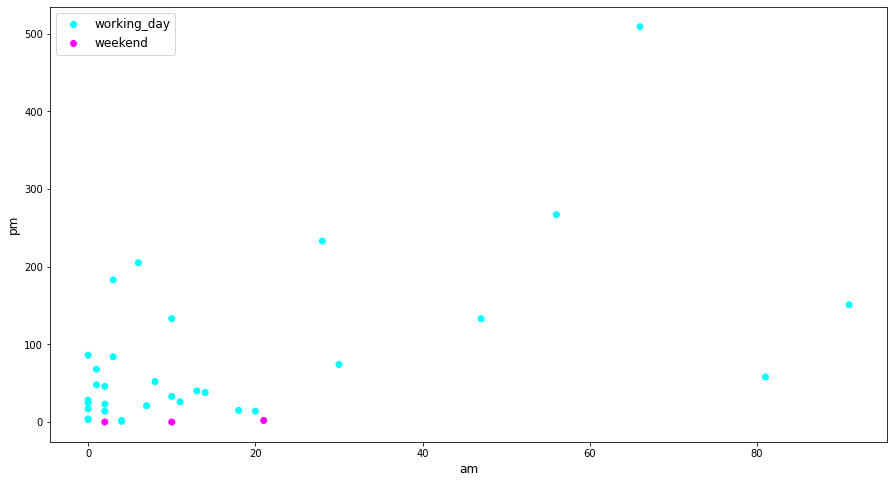

In [24]:
fig, ax = plt.subplots(figsize=(15, 8))
scatter = ax.scatter(x=df['am'], y=df['pm'],
           c=np.where(df['predict'] == 'working_day', 0, 1), cmap='cool')
ax.set_xlabel('am', fontsize='large')
ax.set_ylabel('pm', fontsize='large')
handles, labels = scatter.legend_elements(prop='colors')
ax.legend(handles, ['working_day', 'weekend'],
          loc='upper left', fontsize='large')
plt.show()

In [25]:
accuracy_score(y, y_pred)

0.6285714285714286

In [26]:
y_pred_naive = np.array([np.argmax(np.bincount(y))] * len(y))

In [27]:
accuracy_score(y, y_pred_naive)

0.7142857142857143